# Advanced Lane Line Finding

Distortion correction that was calculated via camera calibration has to be correctly applied to each image. 

In [78]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [79]:
def LoadCameraParams():
    # Read in the saved camera matrix and distortion coefficients
    # These are the arrays you calculated using cv2.calibrateCamera()
    dist_pickle = pickle.load( open( "camera_cal/camera_cal_params_py2.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

    return mtx, dist

mtx, dist = LoadCameraParams()

Text(0.5,1,'Undistorted Image')

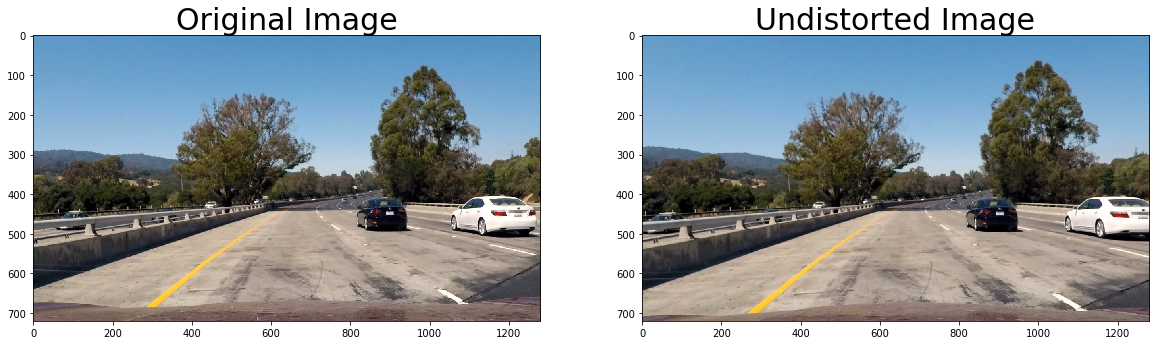

In [80]:
# Read in an image
img = mpimg.imread('test_images/test1.jpg')

# 1) Undistort using mtx and dist
def UndistortImage(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

undist_img = UndistortImage(img, mtx, dist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=30)

### Gradient threshold
---

By using Sobel operator, which is also used in Canny algorithm, we can find derivatives in x and y direction of the image. We use derivatives to find sharp changes in the image what basically represents edges. 
Sobel uses kernel with an odd number size. 
A method or combination of methods (i.e., color transforms, gradients) has been used to create a binary image containing likely lane pixels.

Individual Sobel in X and Y direction is applied with `cv2.Sobel()` function. It does a little bit better job of extracting lanes in X directions, but in the Y they are still visible.

Besides individual Sobels, we can also play with the magnitude, or absolute value, of the gradient. The magnitude is just the square root of the squares of the individual x and y gradients.

Since we're interested only in edges of a particular orientation for lanes, we can explore the direction, or orientation, of the gradient. 
The direction of the gradient is simply the inverse tangent (arctangent) of the yyy gradient divided by the xxx gradient:

In [81]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel=9, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

    # 3) Take the absolute value of the derivative or gradient
    sobel_abs = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(sobel_abs*255 / np.max(sobel_abs))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    
    return binary_output

#For a gradient in both the xxx and yyy directions, the magnitude is the square root of the sum of the squares.

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


Text(0.5,1,'Direction')

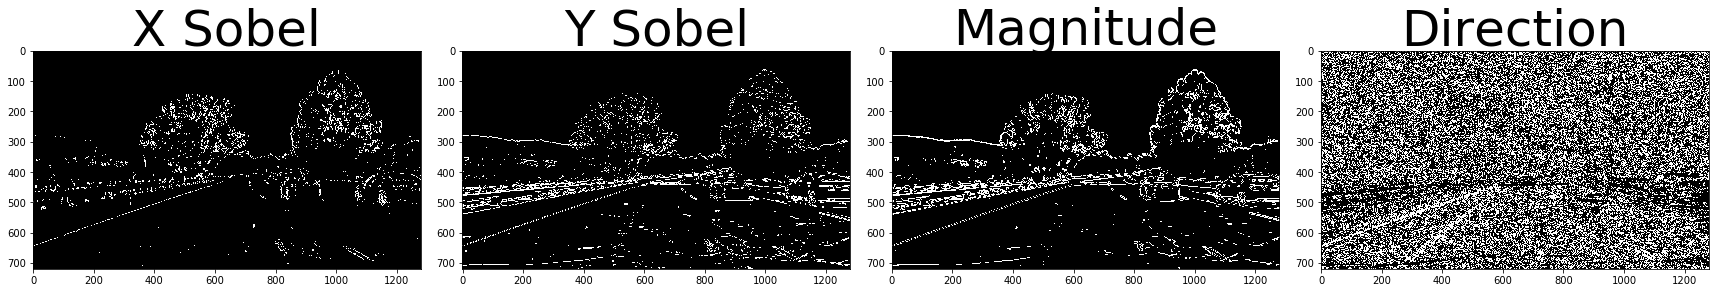

In [82]:
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(undist_img, orient='x', sobel_kernel=5, thresh=(30, 100))
grady = abs_sobel_thresh(undist_img, orient='y', sobel_kernel=5, thresh=(30, 100))
mag_binary = mag_thresh(undist_img, sobel_kernel=9, mag_thresh=(40, 100))
dir_binary = dir_threshold(undist_img, sobel_kernel=9, thresh=(0.7, 1.3))

# Plot the result
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gradx, cmap='gray')
ax1.set_title('X Sobel', fontsize=50)
ax2.imshow(grady, cmap='gray')
ax2.set_title('Y Sobel', fontsize=50)
ax3.imshow(mag_binary, cmap='gray')
ax3.set_title('Magnitude', fontsize=50)
ax4.imshow(dir_binary, cmap='gray')
ax4.set_title('Direction', fontsize=50)

### Color threshold
---
A color space is a specific organization of colors; color spaces provide a way to categorize colors and represent them in digital images.

**RGB** is red-green-blue color space. You can think of this as a 3D space, in this case a cube, where any color can be represented by a 3D coordinate of R, G, and B values. For example, white has the coordinate (255, 255, 255), which has the maximum value for red, green, and blue.

here is also **HSV** color space (hue, saturation, and value), and **HLS** space (hue, lightness, and saturation). These are some of the most commonly used color spaces in image analysis.

To get some intuition about these color spaces, you can generally think of **Hue** as the value that represents color independent of any change in brightness. So if you imagine a basic red paint color, then add some white to it or some black to make that color lighter or darker -- the underlying color remains the same and the hue for all of these colors will be the same.

On the other hand, **Lightness** and **Value** represent different ways to measure the relative lightness or darkness of a color. For example, a dark red will have a similar hue but much lower value for lightness than a light red. **Saturation** also plays a part in this; saturation is a measurement of colorfulness. So, as colors get lighter and closer to white, they have a lower saturation value, whereas colors that are the most intense, like a bright primary color (imagine a bright red, blue, or yellow), have a high saturation value.

Text(0.5,1,'S Channel Regular')

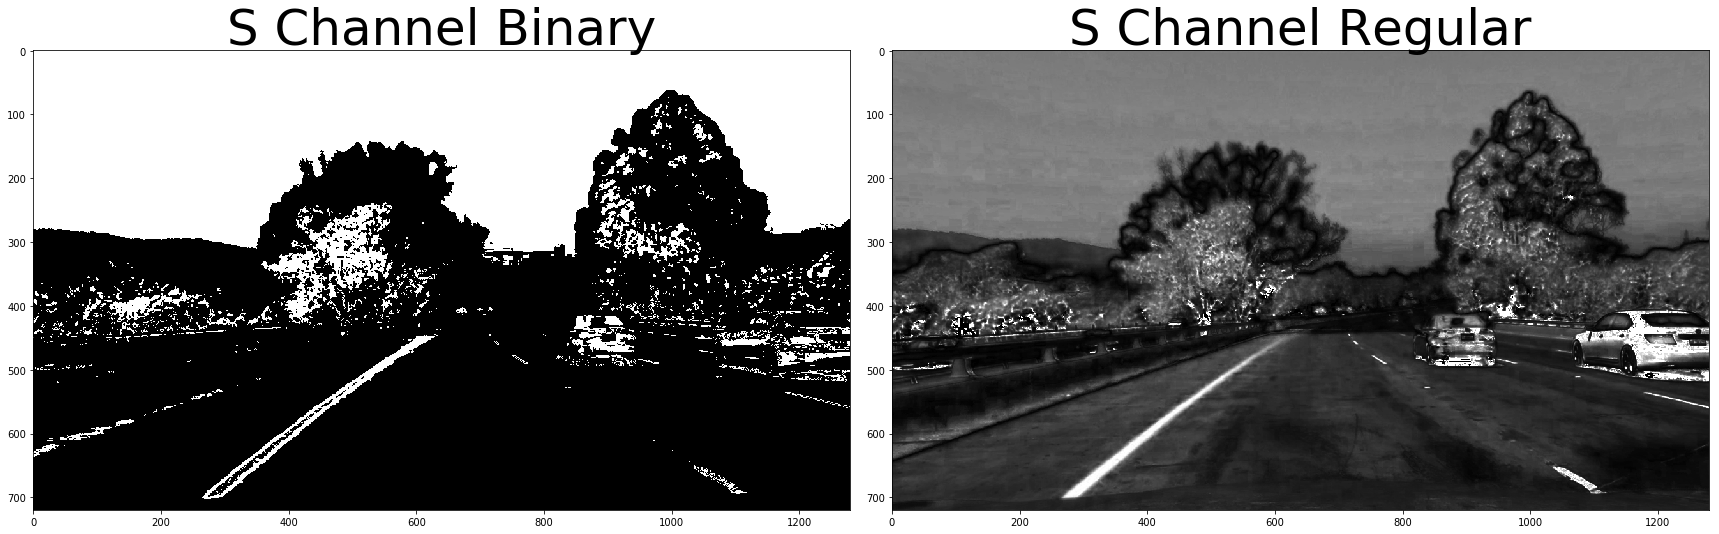

In [83]:
# Function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # 2) Apply a threshold to the S channel
    s =  hls_img[:,:,2]
    
    binary_output = np.zeros_like(s)
    binary_output[(s > thresh[0]) & (s <= thresh[1])] = 1
    
    # 3) Return a binary image of threshold result
    return binary_output, s
    
# Optional TODO - tune the threshold to try to match the above image!    
s_bin, s_channel = hls_select(undist_img, thresh=(90, 250))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(s_bin, cmap="gray")
ax1.set_title('S Channel Binary', fontsize=50)
ax2.imshow(s_channel, cmap='gray')
ax2.set_title('S Channel Regular', fontsize=50)

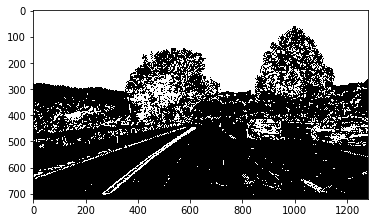

In [84]:
combined = np.zeros_like(gradx)

# Combination of sobel x, s channel and magnitude and direction thresholds
combined[(gradx == 1) | (s_bin == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plt.imshow(combined, cmap="gray")

### Perspective transform
---
Perspective transform maps the points in a given image to different, desired, image points with a new perspective. The perspective transform you’ll be most interested in is a bird’s-eye view transform that let’s us view a lane from above; this will be useful for calculating the lane curvature later on. Aside from creating a bird’s eye view representation of an image, a perspective transform can also be used for all kinds of different view points.

[[  280.   700.]
 [  590.   457.]
 [  725.   457.]
 [ 1125.   700.]]
[[  200.   720.]
 [  200.     0.]
 [ 1200.     0.]
 [ 1000.   720.]]


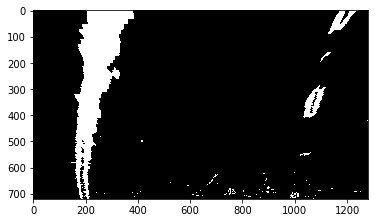

In [101]:
def perspective_transform(img, src, dst):      
    img_size = img.shape[1::-1]
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M

cols, rows = combined.shape[::-1]
top_limit = np.int(rows * 0.635)
down_limit = rows - 20
src_point1 = [280, down_limit]
src_point2 = [590, top_limit]
src_point3 = [725, top_limit]
src_point4 = [1125, down_limit]
src = np.float32([src_point1, src_point2, src_point3, src_point4])

dst_point1 = [200, rows]
dst_point2 = [200, 0]
dst_point3 = [1200, 0]
dst_point4 = [1000, rows]
dst = np.float32([dst_point1, dst_point2, dst_point3, dst_point4])

warped, M = perspective_transform(combined, src, dst)

plt.imshow(warped, cmap="gray")

Polynomial fit on the lane line

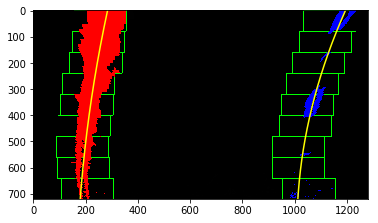

In [102]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    # Obtain line coeffs
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img, left_fit, right_fit, ploty, left_fitx, right_fitx


out_img, left_fit, right_fit, ploty, left_fitx, right_fitx = fit_polynomial(warped)

# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

plt.imshow(out_img)

Next step is to calculate curvature of the lanes needed for steering comamnd nad others

In [103]:
def measure_curvature_real(img_shape, left_lane_coeffs, right_lane_coeffs, ym_per_pix, xm_per_pix):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''

    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])# to cover same y-range as image
    
    leftx = left_lane_coeffs[0]*ploty**2 + left_lane_coeffs[1]*ploty + left_lane_coeffs[2]
    rightx = right_lane_coeffs[0]*ploty**2 + right_lane_coeffs[1]*ploty + right_lane_coeffs[2]
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #right_curverad = 1
    return left_curverad, right_curverad

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30.0/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(undist_img.shape, left_fit, right_fit, ym_per_pix, xm_per_pix)

print(left_curverad, 'm', right_curverad, 'm')

(1684.0604810345596, 'm', 614.32328778164481, 'm')


In [104]:
"""
You can assume the camera is mounted at the center of the car, such that the lane center is the midpoint at the bottom of the image between the two lines you've detected. The offset of the lane center from the center of the image (converted from pixels to meters) is your distance from the center of the lane. 
"""
def GetVehicleOffset(img_shape, left_lane_coeffs, right_lane_coeffs, xm_per_pix):
    y_eval = img_shape[0]

    # This 
    img_center = img_shape[1] / 2

    # calculate postition of left x and right x with given y_eval by applying formula
    leftx = left_lane_coeffs[0]*y_eval**2 + left_lane_coeffs[1]*y_eval + left_lane_coeffs[2]
    rightx = right_lane_coeffs[0]*y_eval**2 + right_lane_coeffs[1]*y_eval + right_lane_coeffs[2]

    center_lane = leftx + rightx // 2

    return (center_lane - img_center) * xm_per_pix

xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Calulcate offset
vehicle_offset = GetVehicleOffset(undist_img.shape, left_fit, right_fit, xm_per_pix)
print(vehicle_offset)

0.236928814663


Now let's visualize all this together.

The fit from the rectified image has been warped back onto the original image and plotted to identify the lane boundaries. This should demonstrate that the lane boundaries were correctly identified.

Lane curvature and vehicle offset from the center are shown in the upper left corner

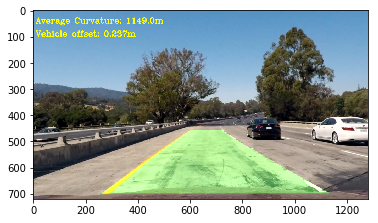

In [105]:
def DrawLaneArea(warped, ploty, left_fitx, right_fitx, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 

    return newwarp

def DrawInfo(img, curve, vehicle_offset):
    avg_curve = (curve[0] + curve[1]) // 2
    
    curvature_info = 'Average Curvature: ' + str(avg_curve) + 'm'

    cv2.putText(img, (curvature_info), (10, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 0), 2, cv2.LINE_AA)
    
    cv2.putText(img, ('Vehicle offset: ' + str(round(vehicle_offset, 3)) + 'm'), (10, 100), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 0), 2, cv2.LINE_AA)
    
    return img

M = cv2.getPerspectiveTransform(dst, src)
new_warp = DrawLaneArea(warped, ploty, left_fitx, right_fitx, M)

# Combine the result with the original image
result = cv2.addWeighted(undist_img, 1, new_warp, 0.3, 0)

result = DrawInfo(result, (left_curverad, right_curverad), vehicle_offset)
plt.imshow(result)

Okay, let's build a pipeline for a video processing

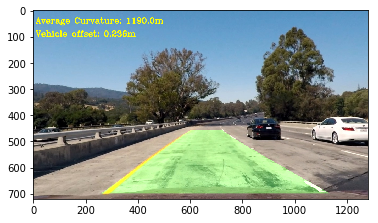

In [106]:
def ProcessLanes(img):
    # Undistort frame
    undist_img = UndistortImage(img, mtx, dist)

    # Apply gradient and color thresholds
    gradx = abs_sobel_thresh(undist_img, orient='x', sobel_kernel=5, thresh=(30, 100))
    mag_binary = mag_thresh(undist_img, sobel_kernel=9, mag_thresh=(40, 100))
    dir_binary = dir_threshold(undist_img, sobel_kernel=9, thresh=(0.7, 1.3))
    s_bin, s_channel = hls_select(undist_img, thresh=(90, 250))

    combined = np.zeros_like(gradx)

    # Combination of sobel x, s channel and magnitude and direction thresholds
    combined[(gradx == 1) | (s_bin == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    # source points for perspective transform and roi at same time
    cols, rows = combined.shape[::-1]
    top_limit = rows * 0.635
    down_limit = rows - 20
    src_point1 = [280, down_limit]
    src_point2 = [590, top_limit]
    src_point3 = [725, top_limit]
    src_point4 = [1125, down_limit]
    src = np.float32([src_point1, src_point2, src_point3, src_point4])

    # destination points in warped image
    dst_point1 = [200, rows]
    dst_point2 = [200, 0]
    dst_point3 = [1200, 0]
    dst_point4 = [1000, rows]
    dst = np.float32([dst_point1, dst_point2, dst_point3, dst_point4])

    warped, M = perspective_transform(combined, src, dst)

    # Find lane coefficents, and other for plotin
    out_img, left_fit_coeffs, right_fit_coeffs, ploty, left_fitx, right_fitx = fit_polynomial(warped)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Calculate the radius of curvature in meters for both lane lines
    left_curverad, right_curverad = measure_curvature_real(undist_img.shape, left_fit_coeffs, right_fit_coeffs, ym_per_pix, xm_per_pix)
    vehicle_offset = GetVehicleOffset(undist_img.shape, left_fit_coeffs, right_fit_coeffs, xm_per_pix)

    M = cv2.getPerspectiveTransform(dst, src)
    new_warp = DrawLaneArea(warped, ploty, left_fitx, right_fitx, M)

    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, new_warp, 0.3, 0)

    # Draw curvature and vehicel offset info onto the final image
    result = DrawInfo(result, (left_curverad, right_curverad), vehicle_offset)

    return result

result = ProcessLanes(img)
plt.imshow(result)

In [107]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

In [108]:
lanes_output = "project_video_output.mp4"
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(ProcessLanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(lanes_output, audio=False)

t:   0%|          | 2/1260 [00:00<01:31, 13.82it/s, now=None]Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4

t: 100%|██████████| 1260/1260 [02:46<00:00,  7.66it/s, now=None]Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: user 4min 38s, sys: 1min 3s, total: 5min 42s
Wall time: 2min 47s


In [ ]:
lanes_output = "challenge_video_output.mp4"
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(ProcessLanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(lanes_output, audio=False)

In [95]:
lanes_output = "harder_challenge_video_output.mp4"
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(ProcessLanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(lanes_output, audio=False)

t:   0%|          | 2/1199 [00:00<01:33, 12.84it/s, now=None]Moviepy - Building video harder_challenge_video_output.mp4.
Moviepy - Writing video harder_challenge_video_output.mp4

t: 100%|██████████| 1199/1199 [02:47<00:00,  7.02it/s, now=None]Moviepy - Done !
Moviepy - video ready harder_challenge_video_output.mp4
CPU times: user 4min 39s, sys: 1min 4s, total: 5min 44s
Wall time: 2min 48s
